**Checking the hardware specifications**

This project is being performed on a Google Colab machine with the following specifications:




In [ ]:
#Check CPU
! lscpu


Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:                        3
CPU MHz:                         2000.150
BogoMIPS:                        4000.30
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        1 MiB
L3 cache:                        38.5 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

In [ ]:
#Check GPU
! nvidia-smi

Sun Apr 30 01:22:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**1: Preparation**

First we will import all necessary libraries and function used for this project.

Then we load the Hospital Length of Stay Dataset. Here we would numericize any non-numeric features and normalize all features containing non-discrete data.

In [ ]:
#Import library
import numpy as np
import math
import os
import time
import statistics as stats

import tensorflow as tf
import pandas as pand
import matplotlib.pyplot as plt
import seaborn
import sklearn

In [ ]:
# Get the required dataset
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1spwkKC_T8s51NFNuz0yU5q6IPgIJXtmr' -O 'LengthOfStay.csv'

--2023-04-30 01:22:33--  https://drive.google.com/uc?export=download&id=1spwkKC_T8s51NFNuz0yU5q6IPgIJXtmr
Resolving drive.google.com (drive.google.com)... 142.251.10.139, 142.251.10.101, 142.251.10.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.10.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ud98nb2hv6skqfehng0n702sahmh2ea6/1682817750000/13548507990689904039/*/1spwkKC_T8s51NFNuz0yU5q6IPgIJXtmr?e=download&uuid=db8a7ef1-9afd-4b8c-84d3-4f021769de11 [following]
--2023-04-30 01:22:35--  https://doc-00-08-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ud98nb2hv6skqfehng0n702sahmh2ea6/1682817750000/13548507990689904039/*/1spwkKC_T8s51NFNuz0yU5q6IPgIJXtmr?e=download&uuid=db8a7ef1-9afd-4b8c-84d3-4f021769de11
Resolving doc-00-08-docs.googleusercontent.com (doc-00-08-docs.googleusercontent.com)... 74.125.68.132, 2404:6

In [ ]:
#Import the necessary functions

#Preprocessing and data exploration:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#Model setting

#Neural network layers
from tensorflow import keras
from keras import layers, regularizers, initializers, activations
#Decision tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#Model compilation
from keras import Model

#Model training and evaluation

#Training
from keras import optimizers

#Evaluation
from keras import metrics as k_metrics
from keras import losses, callbacks
from sklearn import metrics as s_metrics


In [ ]:
#Load and describe the dataset
stay_data = pand.read_csv('./LengthOfStay.csv')
print(f"Dataset shape: {stay_data.shape}")
stay_data.info()

Dataset shape: (100000, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   eid                         100000 non-null  int64  
 1   vdate                       100000 non-null  object 
 2   rcount                      100000 non-null  object 
 3   gender                      100000 non-null  object 
 4   dialysisrenalendstage       100000 non-null  int64  
 5   asthma                      100000 non-null  int64  
 6   irondef                     100000 non-null  int64  
 7   pneum                       100000 non-null  int64  
 8   substancedependence         100000 non-null  int64  
 9   psychologicaldisordermajor  100000 non-null  int64  
 10  depress                     100000 non-null  int64  
 11  psychother                  100000 non-null  int64  
 12  fibrosisandother            100000 non-null  

In [ ]:
# Preview the dataset
stay_data.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4


As seen from the dataset, 
we have 28 features and 100,000 records.

Out of all of the 28 features,
*eid*, *vdate*, *discharged*, and *facid* are administrative attributes about
a patient's stay, and are irrelevant.

The columns "gender" and "rcount" are not completely numericized.

In [ ]:
#Preprocessing the dataset

#Discard irrelevant information
stay_data.drop(columns=['eid', 'vdate', 'facid', 'discharged'], inplace=True)

# Changing "5+" in rcount to number 5,
stay_data['rcount'] = stay_data['rcount'].replace(['0', '1', '2', '3', '4', '5+'],
                                                  [0, 1, 2, 3, 4, 5])
# Assume gender is binarized (0, 1)
stay_data['gender'] = stay_data['gender'].replace(['F', 'M'], [0, 1])

#Segragate the output targets from the input features
stay_data_labels = stay_data[['rcount','lengthofstay']]
print(stay_data_labels)
stay_data.drop(columns=['rcount','lengthofstay'], inplace=True)


       rcount  lengthofstay
0           0             3
1           5             7
2           1             3
3           0             1
4           0             4
...       ...           ...
99995       3             6
99996       0             1
99997       1             4
99998       0             4
99999       0             2

[100000 rows x 2 columns]


In [ ]:
mms = StandardScaler()
scaled = pand.DataFrame(mms.fit_transform(stay_data))

2: Dataset partitioning and preliminary data analysis

First, we will partition the dataset to training, validation and testing partitions in 68:12:20 ratio, while maintaining the distribution of the population in each partition.

However, we need to first examine the distribution of values in "rcount" and "lengthofstay:"

array([[<Axes: title={'center': 'rcount'}>,
        <Axes: title={'center': 'lengthofstay'}>]], dtype=object)

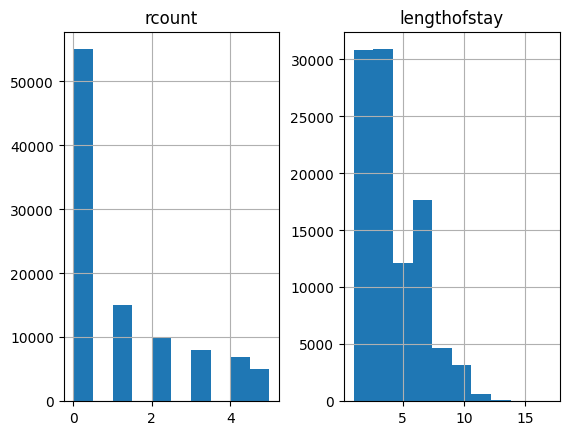

In [ ]:
stay_data_labels.hist(column = ['rcount', 'lengthofstay'])

In [ ]:
stay_data_labels.corr()

,rcount,lengthofstay
rcount,1.000000,0.749514
lengthofstay,0.749514,1.000000


Looking at the whole dataset,
we have the correlation matrix

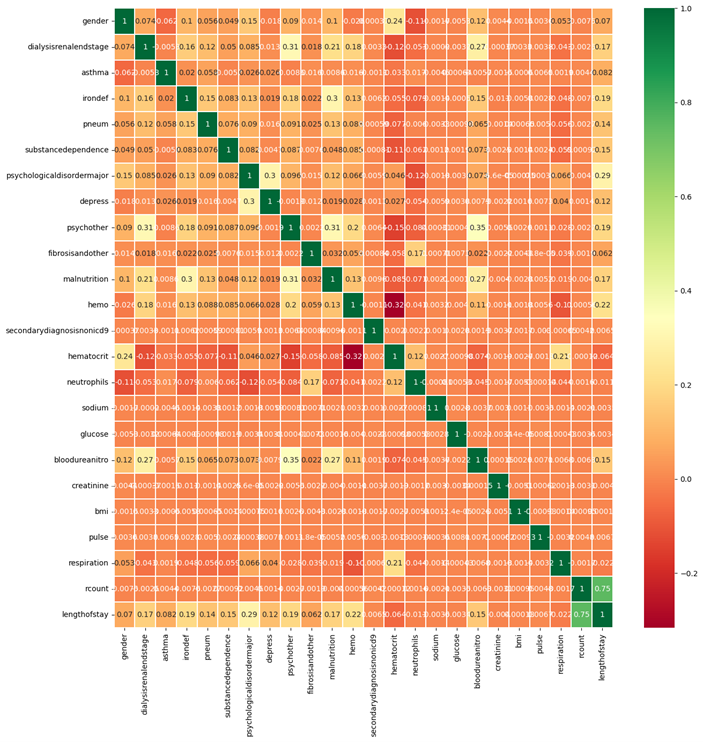



"rcount" and "lengthofstay" will be our labels in the predictive model training.

So it suffices that we apply stratified sampling with the column "rcount":

In [ ]:
#Split the datasets into training and testing partitions

feat_train, feat_test, label_train, label_test = train_test_split(
    stay_data, stay_data_labels, test_size=0.2, random_state=721,
    stratify=stay_data_labels['rcount']
)

**3. Model setting**

In this project, the task of predicting the number of readmissions and the length of hospital stay is being done simultaneously.

*a. Dimensionality reduction*

We implement a method to lower the dimension of input features while minimizing data loss: 

Autoencoder

In [ ]:
# A simple autoencounter
class Autoencoder(layers.Layer):
  # Parameters:
  # n_bottleneck: dimension of bottleneck layer
  # n_output: dimension of output layer
  # activation: activation function, default is ReLU
  def __init__(self, n_bottleneck, n_output, activation = "elu"):
    super().__init__()
    #Encoder
    self.encode = layers.Dense(units = n_bottleneck, activation = activation)
    #Decoder
    self.decode = layers.Dense(units = n_output, activation = activation)
  
  def call(self, x):
    x1 = self.encode(x)
    x2 = self.decode(x1)
    return x2

*b. General neural network layers*

In [ ]:
class common_resnet(layers.Layer):
  #The common ResNet
  # Parameters:
  # n_input: dimension of input and output layers, since skip connection is used
  # no_layers: number of fully connected layers
  # n_units_layers: list of dimensions of fully connected layers
  # activation: activation function, default is ReLU
  # L2_rate: L2 regularization factor
  def __init__(self, n_input, no_layers, n_units_layers, 
               activation = "relu",
               L2_rate=0.001):

    super().__init__()
    #Sequence of layers in ResNet
    self.mid_layer = []
    #For each fully connected layer, we have
    for i in range(no_layers):
      #An FC layer equipped with L2
      self.mid_layer.append(layers.Dense(units = n_units_layers[i],
                                         activity_regularizer=regularizers.L2(L2_rate)))
      #A batch normalization layer
      self.mid_layer.append(layers.BatchNormalization())
      #A non-linear activation layer
      self.mid_layer.append(layers.LeakyReLU(0.3))
    self.final_layer = layers.Dense(units=n_input, activation=activation)
  
  def call(self, x):
    # Beginning of skip connection
    x_skip = x
    # The ResNet component
    for lyr in self.mid_layer:
      x = lyr(x)
    x = self.final_layer(x)
    # End of skip connection
    return x + x_skip

*c. Regression and classification layers*

In [ ]:
class final_layers(layers.Layer):
  def __init__(self, n_input, activation = "relu"):
    super().__init__()
    #Function towards regression/classification layer
    self.layer_1 = layers.Dense(units=math.floor(n_input/2), activation = activation, 
                              activity_regularizer=regularizers.L2(1e-5))
    #Function to output
    self.layer_2 = layers.Dense(units=1, activation = activation)
  def call(self, x):
    x = self.layer_1(x)
    return self.layer_2(x)

*d. Decision trees*

In [ ]:
# We will build the decision tree regressor and classifier soon.

**Building the models**

We now construct the models by putting all the components altogether.

In [ ]:
#Initialize the model default parameters

#Training parameters
feature_size = feat_train.shape[1]
batch_size = 200

#Common activation function
# Choice: "relu", "elu", "sigmoid"
activation = "elu"

#Dimensionality reduction
#Selection of which dimensionality reduction algorithm to use: 0: None, 1: Autoencoder
dr_toggle = 0
#Dimension of autoencoder bottleneck layer if used
n_autoencoder_neck = 10

#Neural network regression and classification

#Common ResNet
#No of fully connected layers (i.e., blocks)
no_layers = 4
#Dimensions of fully connected layers
n_units_layers = [44, 60, 60, 44]
#L2 regularizer factor
l2_r = 0.01

#Decision tree parameters
crit_regress = "squared_error"
crit_classify = "entropy"
split = "best"
# All other parameters(max_depth, min_samples_split, ...) are set to default

In [ ]:
#Neural network model builder
def nn_model_gen(dr_switch = dr_toggle, #Dimensionality reduction algorithm choice
                 n_neck = n_autoencoder_neck, #Bottleneck layer dimensions of autoencoder
                 activation = activation, #Common activation function
                 no_layers = no_layers, #No of sequential block inside a Common ResNet
                 n_units_layers = n_units_layers, #No. of FC layers per sequential block
                 l2_r = l2_r, #L2 regularization
                 ):
  #Input dimensions at beginning of NN model
  nn_input = keras.Input((feature_size,))
  
  #Dimensionality reduction models
  if dr_switch == 1:
    x = Autoencoder(n_neck, feature_size, activation)(nn_input)
  else:
    x = nn_input

  #Common ResNets
  for _ in range(4):
    x = common_resnet(feature_size, 
                      no_layers, 
                      n_units_layers,
                      activation,
                      l2_r)(x)
  #Length of stay
  y1 = final_layers(feature_size, activation)(x)
  #Readmission count
  y2 = final_layers(feature_size, activation)(x)

  return keras.Model(inputs=nn_input, outputs=[y1, y2])

#Set up decision tree models
#Regression
los_tree = DecisionTreeRegressor(criterion = "squared_error", splitter = "best")
#Classification
readm_tree = DecisionTreeClassifier(criterion = "squared_error", splitter = "best")

**Model and hyperparameter setup**

Here we setup the model hyperparameters, optimizers, metrics and loss functions:

In [ ]:
param_1 = {
    "dr_switch": 0,
    "n_neck": None,
    "activation": "sigmoid",
    "no_layers": 4,
    "n_units_layers": [35, 35, 35, 35],
    "l2_r": 0.001
}
param_2 = {
    "dr_switch": 0,
    "n_neck": None,
    "activation": "elu",
    "no_layers": 4,
    "n_units_layers": [28, 28, 28, 28],
    "l2_r": 0.01
}
param_3 = {
    "dr_switch": 0,
    "n_neck": None,
    "activation": "relu",
    "no_layers": 3,
    "n_units_layers": [46, 46, 46],
    "l2_r": 0.01
}
param_4 = {
    "dr_switch": 1,
    "n_neck": 10,
    "activation": "sigmoid",
    "no_layers": 2,
    "n_units_layers": [70, 70],
    "l2_r": 0.001
}
param_5 = {
    "dr_switch": 1,
    "n_neck": 11,
    "activation": "elu",
    "no_layers": 4,
    "n_units_layers": [35, 35, 35, 35],
    "l2_r": 0.01
}
param_6 = {
    "dr_switch": 1,
    "n_neck": 10,
    "activation": "relu",
    "no_layers": 2,
    "n_units_layers": [56, 56],
    "l2_r": 0.001
}

In [ ]:
#Set up model optimizer, loss and metric function, and callbacks
our_optimizer = optimizers.Adam(
    learning_rate = 5e-4,
    beta_1 = 0.94,
    beta_2 = 0.9994,
    epsilon = 5e-7,
)
#Regression
los_loss = losses.MeanSquaredError()
#Classification
readm_loss = losses.CategoricalCrossentropy()

#Callbacks
my_callbacks = [
    callbacks.EarlyStopping(),
    callbacks.ModelCheckpoint(
        filepath = "best_weight.h5",
        save_weights_only = True,
        monitor = 'val_loss',
        mode = 'min',
        save_best_only = True
    )
]

Sample the datasets and
convert the datasets into Numpy array

In [ ]:
def convert(X, y, sample_frac=1):
  X = X.sample(frac=sample_frac)
  y = y.sample(frac=sample_frac)
  return X.to_numpy(), y.to_numpy()

**4. Model training**
At long last, we are now ready to train:

1. Neural networks

In [ ]:
#Select parameter set
param_sets = [param_1, param_2, 
              param_3, param_4,
              param_5, param_6]
#####################
#####################
# Select a number from 1 to 6 (7: ablation study parameter)
set_choice = 5
#####################
param_set = param_sets[set_choice-1]
####################
####################
###Sampling fractions (0.1, 0.2, ..., 0.9, 1)
sample_frac = 0.3
####################

#Training

get_model = nn_model_gen(**param_set)
get_model.compile(optimizer=our_optimizer, 
                  loss=[los_loss, readm_loss]
                  )


In [ ]:
batchs = 200
epochs = 15

In [ ]:
#Sample data
feat_train_n, label_train_n = convert(feat_train, label_train, sample_frac)
feat_test_n, label_test_n = convert(feat_test, label_test, sample_frac)

print(feat_train_n.shape)

# Fit the model
history = get_model.fit(feat_train_n, [label_train_n[:,1], label_train_n[:,0]],
                        batch_size = batchs, epochs = epochs,
                        verbose = 1, callbacks = my_callbacks,
                        validation_split=0.15)
test_results = get_model.evaluate(feat_test_n, [label_test_n[:,1], label_test_n[:,1]],
                                  verbose=1, batch_size=batch_size)
print(test_results)

(24000, 22)
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(200, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


102/102 [==============================] - 16s 42ms/step - loss: 99.9040 - final_layers_loss: 9.3427 - final_layers_1_loss: 1.3381e-07 - val_loss: 30.8300 - val_final_layers_loss: 5.9598 - val_final_layers_1_loss: 1.3643e-07
Epoch 2/15
102/102 [==============================] - 4s 35ms/step - loss: 18.5252 - final_layers_loss: 5.7386 - final_layers_1_loss: 1.3381e-07 - val_loss: 16.0664 - val_final_layers_loss: 6.0432 - val_final_layers_1_loss: 1.3643e-07
Epoch 3/15
102/102 [==============================] - 3s 28ms/step - loss: 10.7402 - final_layers_loss: 5.7147 - final_layers_1_loss: 1.3381e-07 - val_loss: 11.5531 - val_final_layers_loss: 5.9588 - val_final_layers_1_loss: 1.3643e-07
Epoch 4/15
102/102 [==============================] - 2s 19ms/step - loss: 8.7568 - final_layers_loss: 5.6971 - final_layers_1_loss: 1.3381e-07 - val_loss: 9.5641 - val_final_layers_loss: 5.5955 - val_final_layers_1_loss: 1.3643e-07
Epoch 5/15
102/102 [==============================] - 1s 13ms/step - los

In [ ]:
regress_loss_record = history.history['final_layers_loss']
val_regress_loss_record = history.history['val_final_layers_loss']

classify_loss_record = history.history['final_layers_1_loss']
val_classify_loss_record = history.history['val_final_layers_1_loss']
#Check results
results = [
    min(regress_loss_record),
    min(val_regress_loss_record),
    test_results[1],
    min(classify_loss_record),
    min(val_classify_loss_record),
    test_results[2],
]
print(results)

[5.693711757659912, 5.595513343811035, 5.634522914886475, 1.338124349103964e-07, 1.3642842588978965e-07, 4.7588352458660665e-07]


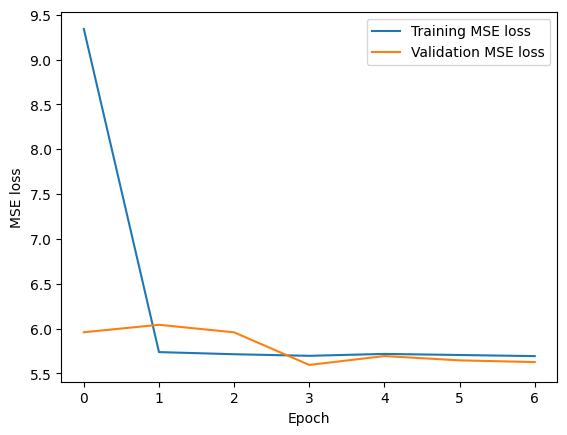

In [ ]:
plt.plot(history.history['final_layers_loss'], label="Training MSE loss")
plt.plot(history.history['val_final_layers_loss'], label="Validation MSE loss")
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.legend(["Training MSE loss", "Validation MSE loss"])
plt.show()

2. Decision trees

In [ ]:
sampler = np.linspace(0.01, 1, 100)

train_mse_score = []
train_acc_score = []
test_mse_score = []
test_acc_score = []

for frac in sampler:
  #Sample dataset
  feat_train_tree, label_train_tree = convert(feat_train, label_train, sample_frac)
  feat_test_tree, label_test_tree = convert(feat_test, label_test, sample_frac)
  #Get skeleton
  los_tree = DecisionTreeRegressor(criterion = "squared_error", splitter="best")
  readm_tree = DecisionTreeClassifier(criterion = "entropy", splitter="best")
  #Fit model
  los_tree.fit(feat_train_tree, label_train_tree[:,1])
  readm_tree.fit(feat_train_tree, label_train_tree[:,0])

  #Get training score
  expected_los_train = los_tree.predict(feat_train_tree)
  expected_readm_train = readm_tree.predict(feat_train_tree)
  train_mse = s_metrics.mean_squared_error(label_train_tree[:,1], expected_los_train)
  train_acc = s_metrics.accuracy_score(label_train_tree[:,0], expected_readm_train)
  
  train_mse_score.append(train_mse), train_acc_score.append(train_acc)

  #Get test score
  expected_los_test = los_tree.predict(feat_test_tree)
  expected_readm_test = readm_tree.predict(feat_test_tree)
  test_mse = s_metrics.mean_squared_error(label_test_tree[:,1], expected_los_test)
  test_acc = s_metrics.accuracy_score(label_test_tree[:,0], expected_readm_test)

  test_mse_score.append(test_mse), test_acc_score.append(test_acc)

[11.750166666666667, 12.098, 11.560833333333333, 11.551, 11.839833333333333, 11.3215, 11.66, 11.565833333333334, 11.634833333333333, 11.624833333333333, 11.695166666666667, 11.326, 11.311333333333334, 11.863166666666666, 11.873333333333333, 11.563666666666666, 11.239, 11.768333333333333, 11.592166666666667, 11.696, 11.649333333333333, 11.580333333333334, 11.7785, 11.849333333333334, 11.5, 11.700333333333333, 11.6325, 11.823666666666666, 11.975833333333334, 11.417833333333334, 11.442833333333333, 11.905333333333333, 11.405833333333334, 11.707666666666666, 11.432333333333334, 11.544666666666666, 11.360333333333333, 11.447833333333334, 11.724, 11.332166666666666, 11.182333333333334, 11.428166666666666, 11.460833333333333, 11.608333333333333, 11.478, 11.412166666666666, 11.605333333333334, 11.7265, 11.282333333333334, 11.909166666666666, 11.413333333333334, 11.6085, 11.5085, 11.615166666666667, 11.5595, 11.403833333333333, 11.735333333333333, 11.766333333333334, 11.694666666666667, 11.717,

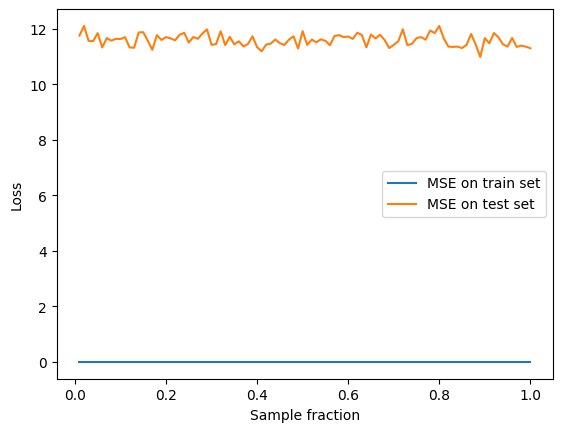

In [ ]:
print(test_mse_score, test_acc_score)

plt.plot(sampler, train_mse_score, label="MSE on train set")
plt.plot(sampler, test_mse_score, label="MSE on test set")
plt.xlabel('Sample fraction')
plt.ylabel('Loss')
plt.legend()
plt.show()

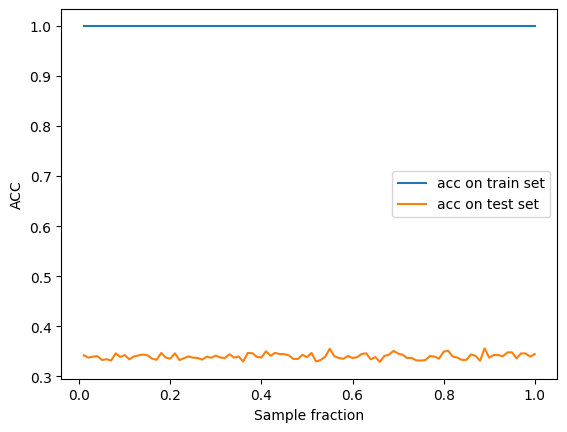

In [ ]:
plt.plot(sampler, train_acc_score, label="acc on train set")
plt.plot(sampler, test_acc_score, label="acc on test set")
plt.xlabel('Sample fraction')
plt.ylabel('ACC')
plt.legend()
plt.show()

In [ ]:
#Depth of regression tree
print(los_tree.tree_.max_depth)

63


In [ ]:
#Depth of classifier
print(readm_tree.tree_.max_depth)

67
